In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# read the config file
config_file = "kdv.json"
solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)

# set up the grid
Nx = 128
x_max = torch.pi
x_min = -torch.pi
x_step = (x_max - x_min) / (Nx - 1)
x_grid = torch.linspace(x_min, x_max, Nx).unsqueeze(0)

# initial condition: eta(x) = b1 exp(-(x-pi/2)) + b2 (-sin(x/2)^2) + b3 exp(-(x+pi/2)^2)
def sample_func(row_size, col_size):
  assert (col_size == Nx)
  x = x_grid.expand(row_size, Nx)
  # torch.manual_seed(0)
  uniform = torch.tensor([1.0, 1.0, 1.0])
  b = torch.distributions.Dirichlet(uniform).sample((row_size,))
  b1 = b[:, 0].view(-1, 1)
  b2 = b[:, 1].view(-1, 1)
  b3 = b[:, 2].view(-1, 1)
  eta = b1 * torch.exp(-(x - torch.pi / 2)**2) - b2 * torch.sin(
      x / 2)**2 + b3 * torch.exp(-(x + torch.pi / 2)**2)
  return eta

def mass_func(x):
  mass = torch.sum(x, dim=1, keepdim=True) * x_step
  return mass

def momentum_func(x):
  momentum = torch.sum(x **2, dim=1, keepdim=True) * x_step
  return momentum

def observable_func(x):
  mass = mass_func(x)
  momentum = momentum_func(x)
  return torch.cat((mass, momentum), dim=1)


# set up the solver
solver.load_dataset_setup("data/linear_kdv_dataset.pt", observable_func, sample_func)
K = solver.solve()
koopman_dynamics = pkdl.KoopmanODEDynamics(solver.dynamics, K, solver.dictionary, solver.dynamics.dim, solver.dynamics.param_dim)

FileNotFoundError: [Errno 2] No such file or directory: 'data/linear_kdv_dataset.pt'

## Solve the Tracking Problem

In [3]:
traj_len = solver.traj_len * 2
t_step = solver.t_step
time_horizon = 10
lambda_param = 0.005

state0 = torch.zeros(solver.dynamics.dim) + 0.2
mass_ref = torch.zeros(traj_len, 1)
momentum_ref = torch.zeros(traj_len, 1)



for i in range(traj_len):
  if i > traj_len / 2:
    mass_ref[i, :] = 3.16
    momentum_ref[i, :] = 1.58
  else:
    mass_ref[i, :] = 1.90
    momentum_ref[i, :] = 0.57


# mass_solver = pkdl.KoopmanMPCSolver(solver.dynamics, K, solver.dictionary, mass_ref, time_horizon, 1, lambda_param)
# mass_controls, mass_traj = mass_solver.solve(state0, -1, 1)

momentum_solver = pkdl.KoopmanMPCSolver(solver.dynamics, K, solver.dictionary, momentum_ref, time_horizon, 2, lambda_param)
momentum_controls= momentum_solver.solve(state0, -1, 1)


2024-11-18 17:38:42,718 PKoopmanDL: [INFO] [KoopmanMPCSolver] Solving the optimal control problem...
Solving:   0%|          | 0/990 [00:00<?, ?it/s]

Solving: 100%|██████████| 990/990 [1:17:05<00:00,  4.67s/it, loss=1.84e-04]


In [4]:

momentum_traj = koopman_dynamics.traj(state0.unsqueeze(0), momentum_controls.to(torch.float32), traj_len)
t_grid = np.arange(0, traj_len)


Generating trajectory: 100%|██████████| 999/999 [56:11<00:00,  3.37s/it] 


/tmp/ipykernel_3016995/1436528719.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='best',prop={'size':14})


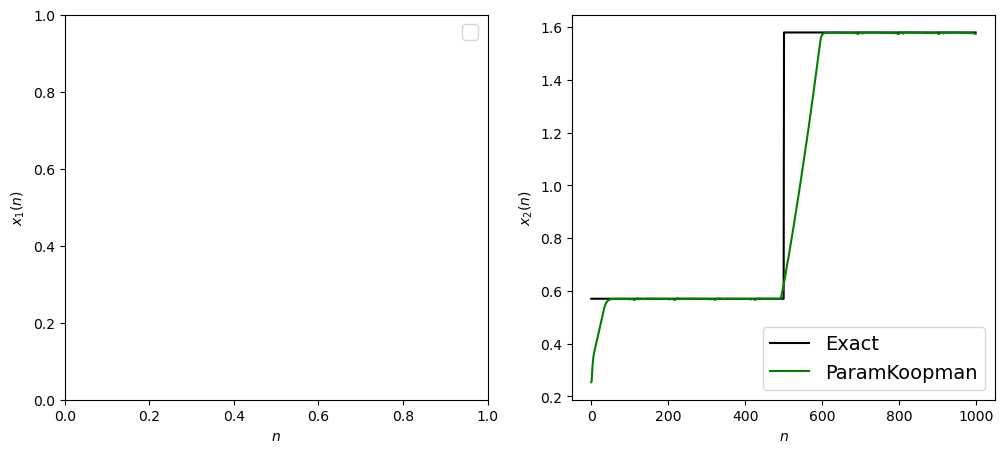

In [5]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  
# ax1.plot(t_grid, mass_ref[:,0], 'k-', label='Exact', markevery=2)
# ax1.plot(t_grid, mass_traj[:,1], 'gs', label='ParamKoopman', markevery=2)

ax2.plot(t_grid, momentum_ref.detach().numpy()[:,0], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, momentum_traj.detach().numpy()[0,:,2], 'g-', label='ParamKoopman', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})